In [1]:
import sys, os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from time import sleep

from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D, MaxPool2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.utils import np_utils
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image

import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

C:\Apps\anaconda3\envs\usabcheckEnv2\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.3) or chardet (2.0.3) doesn't match a supported version!
  RequestsDependencyWarning)
Using TensorFlow backend.


In [5]:
trainDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/Training'
validationDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PublicTest'
testDataDir = 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PrivateTest'

In [41]:
dataLabels = {
    "Angry": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Sad": 4, "Surprise": 5, "Neutral": 6 
}

def loadDataset(datasetDirectory):
    global dataLabels
    data = []
    labels = []
    
    emotionDirList = os.listdir(datasetDirectory)
    for folder in emotionDirList:
        # Folder exists but has not been selected so we ignore it
        if folder not in dataLabels.keys():
            continue
        
        label = dataLabels[folder]
        
        # Iterate over the images
        imageList = os.listdir(datasetDirectory + "/" + folder)
        for imgName in imageList:
            img = cv2.imread(datasetDirectory + '/'+ folder + '/'+ imgName)
            img=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (48,48), interpolation=cv2.INTER_AREA)
            data.append(np.array(img.ravel(),'float32'))
            labels.append(label)
    
    return data, labels


X_train, train_y = loadDataset(trainDataDir)
X_valid, valid_y = loadDataset(validationDataDir)
X_test, test_y = loadDataset(testDataDir)

X_train = np.array(X_train,'float32')
train_y = np.array(train_y,'float32')

X_valid = np.array(X_valid,'float32')
valid_y = np.array(valid_y,'float32')

X_test = np.array(X_test,'float32')
test_y = np.array(test_y,'float32')

print("Train", train_y.shape, X_train.shape)
print("Valid", valid_y.shape, X_valid.shape)
print("Test", test_y.shape, X_test.shape)
not_categorial_valid_y = valid_y.copy()
not_categorial_test_y = test_y.copy()
not_categorial_train_y = train_y.copy()

Train (28709,) (28709, 2304)
Valid (3589,) (3589, 2304)
Test (213,) (213, 2304)


In [39]:
num_features = 64
num_labels = 7
batch_size = 32
epochs = 30
width, height = 48, 48

train_y = np_utils.to_categorical(train_y, num_classes=num_labels)
valid_y = np_utils.to_categorical(valid_y, num_classes=num_labels)

# Data is normalized between 0 and 1
# Train
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
# Validation
X_valid -= np.mean(X_valid, axis=0)
X_valid /= np.std(X_valid, axis=0)
# Validation
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)
# Reshape
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_valid = X_valid.reshape(X_valid.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
""" ---------------------------------------------------------------
    Model Creation and Training
--------------------------------------------------------------- """

trainModel = False

# 1st convolution layer
model = Sequential()

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(X_train.shape[1:])))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
model.add(Dropout(0.5))

# 3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

model.add(Flatten())

# Fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_labels, activation='softmax'))

model.summary()

# Compliling the model
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

csv_logger = CSVLogger('training.log', separator=',', append=False)


if trainModel:
    # Training the model
    history = model.fit(X_train, train_y,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_valid, valid_y),
              shuffle=True,
              callbacks=[csv_logger])


    # Saving the  model to  use it later on
    fer_json = model.to_json()
    with open("Model2.json", "w") as json_file:
        json_file.write(fer_json)
    model.save_weights("Model2_Weights.h5")

In [31]:
""" ------------------------------------------------------
    Plot Confusion Matrix
------------------------------------------------------ """

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, plotIndex=1, fig=plt.figure(num=None, figsize=(20, 30), dpi=80, facecolor='w', edgecolor='k')):
    fig.add_subplot(9, 2, plotIndex)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        pass
        # print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

<Figure size 1600x2400 with 0 Axes>

In [24]:
# Read the model that was previously trained
json_file = open('C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Src/Model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("Model2_Weights.h5")
predictions = model.predict(x=X_test, verbose=0)
previous_history = pd.read_csv('training.log', sep=',', engine='python')

In [27]:
# emotionsList = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# cm = confusion_matrix(y_true=not_categorial_test_y, y_pred=np.argmax(predictions, axis=-1))
# plot_confusion_matrix(cm=cm, classes=emotionsList, title='JAFFE')

In [45]:
""" ------------------------------------------------------
    Get Predicition Data
------------------------------------------------------ """

# Disable if you have already made the calculation
calculatePredictions = True

testDatasets = {
    "JAFFE": 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/JAFFE/Categorised',
    "JAFFE (Face Crop)":   'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/JAFFE/JustFace',
    "FacesDB (Face Crop)": 'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FacesDB/JustFace',
    "FER2013 (Test Set)":  'C:/Users/New User/Desktop/Fourth Year/Usability_Testing_FYP/Datasets/FER2013/Images/PrivateTest'
}

if calculatePredictions:
    resultDict = {}
    
    # Make Predictions
    for datasetTitle in testDatasets.keys():
        datasetPath = testDatasets[datasetTitle]
        
        X_test1, test_y1 = loadDataset(datasetPath)
        X_test1 = np.array(X_test1,'float32')
        test_y1 = np.array(test_y1,'float32')
        not_categorial_test_y1 = test_y1.copy()
        
        X_test1 -= np.mean(X_test1, axis=0)
        X_test1 /= np.std(X_test1, axis=0)
        X_test1 = X_test1.reshape(X_test1.shape[0], 48, 48, 1)
        
        predictions1 = model.predict(x = X_test1, verbose=0)

        resultDict[datasetTitle] = {
            "predicted": np.argmax(predictions1, axis=-1),
            "actual": not_categorial_test_y1
        }
        
#         emotionsList = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
#         cm = confusion_matrix(y_true=not_categorial_test_y1, y_pred=np.argmax(predictions1, axis=-1))
#         plot_confusion_matrix(cm=cm, classes=emotionsList, title='JAFFE')

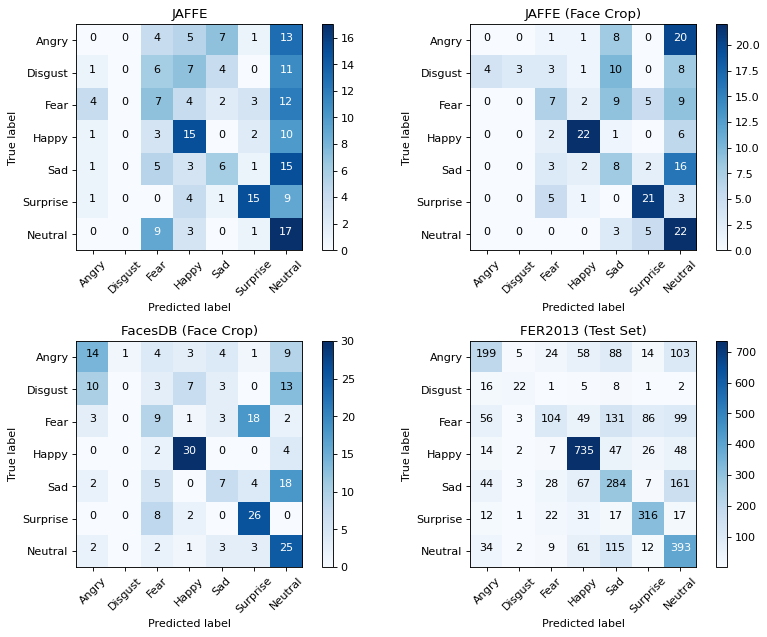

In [46]:
""" ------------------------------------------------------
    Display Results (Confusion Matrix)
------------------------------------------------------ """

# Model 2
# emotionsList = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

emotionsList = list(dataLabels.keys())

plotIndex = 1
fig = plt.figure(num=None, figsize=(10, 35), dpi=80, facecolor='w', edgecolor='k')
for datasetTitle in resultDict:
    actual = resultDict[datasetTitle]["actual"]
    predicted = resultDict[datasetTitle]["predicted"]
    
    cm = confusion_matrix(y_true = actual, y_pred = predicted)
    plot_confusion_matrix(cm=cm, classes=emotionsList, title=datasetTitle, plotIndex=plotIndex, fig=fig)
    plotIndex += 1

In [47]:
""" ------------------------------------------------------
    Display Results (Classification Report)
------------------------------------------------------ """

import warnings
# A warning is thrown because sometimes there prediction has been made 0 times
warnings.filterwarnings('ignore')

reportData = {}

for datasetTitle in resultDict:
    print("----------------------", datasetTitle, "----------------------\n")
    actual = resultDict[datasetTitle]["actual"]
    predicted = resultDict[datasetTitle]["predicted"]
    report = classification_report(actual, predicted)
    reportDict = classification_report(actual, predicted, output_dict=True)
    reportData[datasetTitle] = reportDict
    print(report)
    print("\n\n\n")
    
warnings.filterwarnings('default')

---------------------- JAFFE ----------------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       0.00      0.00      0.00        29
         2.0       0.21      0.22      0.21        32
         3.0       0.37      0.48      0.42        31
         4.0       0.30      0.19      0.24        31
         5.0       0.65      0.50      0.57        30
         6.0       0.20      0.57      0.29        30

    accuracy                           0.28       213
   macro avg       0.25      0.28      0.25       213
weighted avg       0.25      0.28      0.25       213





---------------------- JAFFE (Face Crop) ----------------------

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        30
         1.0       1.00      0.10      0.19        29
         2.0       0.33      0.22      0.26        32
         3.0       0.76      0.71      0.73        31
         4

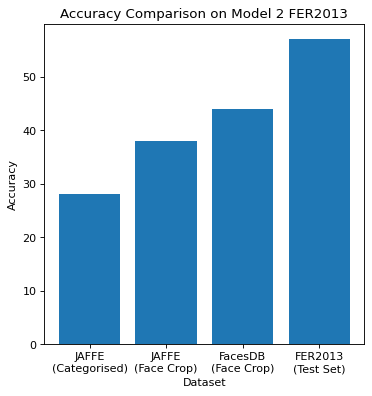

In [49]:
""" ------------------------------------------------------
    Display Accuracy Comparisons
------------------------------------------------------ """

import matplotlib.pyplot as plt
fig = plt.figure(num=None, figsize=(4, 4), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
datasetTitles = []
accuracies = []

titleDisplayPair = {
    "JAFFE": "JAFFE\n(Categorised)",
    "JAFFE (Face Crop)": "JAFFE\n(Face Crop)",
    "FacesDB (Face Crop)": "FacesDB\n(Face Crop)",
    "FER2013 (Test Set)":  "FER2013\n(Test Set)"
}

for title in reportData:
    datasetTitles.append(titleDisplayPair[title])
    accuracy = int(reportData[title]["accuracy"] * 100)
    accuracies.append(accuracy)

ax.bar(datasetTitles, accuracies)
ax.set_xlabel('Dataset')
ax.set_title('Accuracy Comparison on Model 2 FER2013')
ax.set_ylabel('Accuracy')
# ax.set_ylim([0,100])
plt.show()

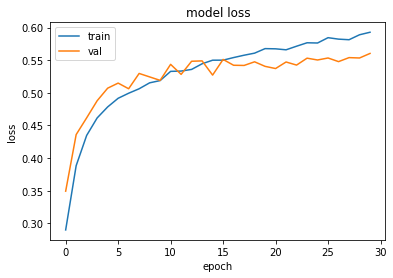

Trained Model not in memory


In [35]:
try:
    plt.plot(previous_history.accuracy)
    plt.plot(previous_history.val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Previous Model not loaded")

try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Trained Model not in memory")

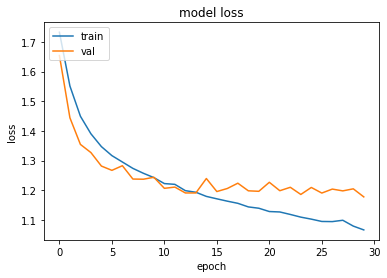

Trained Model not in memory


In [36]:
try:
    plt.plot(previous_history.loss)
    plt.plot(previous_history.val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Previous Model not loaded")

try:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
except:
    print("Trained Model not in memory")

In [25]:
predicted = np.argmax(predictions, axis=1)
report = classification_report(np.argmax(valid_y, axis=1), predicted)
print(report)

              precision    recall  f1-score   support

           0       0.50      0.39      0.44       467
           1       0.58      0.39      0.47        56
           2       0.46      0.17      0.24       496
           3       0.73      0.81      0.77       895
           4       0.43      0.46      0.44       653
           5       0.68      0.78      0.73       415
           6       0.45      0.61      0.52       607

    accuracy                           0.56      3589
   macro avg       0.55      0.52      0.52      3589
weighted avg       0.55      0.56      0.54      3589



In [32]:
""" ---------------------------------------------------------------
    Making live predictions with camera
--------------------------------------------------------------- """


selectedModel = "Model 1"

if selectedModel == "Model 1":
    classifier = load_model(r'Model1.h5')
    labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]
    
elif selectedModel == "Model 2":
    classifier = model_from_json(open("Model2.json", "r").read())
    classifier.load_weights('Model2_Weights.h5')
    labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
else:
    raise "No existing model selected"


faceDetector = cv2.CascadeClassifier(r'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    # Get frame from camera
    ret, frame = cap.read()
    # Convert to grayscale
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    # Detect the face
    faces = faceDetector.detectMultiScale(gray, 1.3, 5)
    
    # Iterate over the faces (bounding boxes)
    for (x, y, w, h) in faces:
        # Draw the rectangle bounding box of face
#         cv2.rectangle(frame, (x,y), (x+w, y+h),(255,0,0), 2)
        croppedFace = gray[y:y+h, x:x+w]
        # Resize the face to the size the classifier expects (48 x 48)
        croppedFace = cv2.resize(croppedFace, (48,48), interpolation=cv2.INTER_AREA)

        # If a face has been detected and the image has pixel values
        if np.sum([croppedFace]) != 0:
            label = None
            if selectedModel == "Model 1":
                roi = croppedFace.astype('float')/255.0
                roi = img_to_array(roi)
                roi = np.expand_dims(roi, axis=0)
                preds = classifier.predict(roi)[0]
                label=labels[preds.argmax()]
            
            elif selectedModel == "Model 2":
                predData = []
                predData.append(np.array(croppedFace.ravel(),'float32'))
                predNp = np.array(predData,'float32')
                predNp = predNp.reshape(predNp.shape[0], 48, 48, 1)
                pred1 = classifier.predict(x=predNp, verbose=0)
                y_pred = np.argmax(pred1, axis=-1)
                label = labels[y_pred[0]]

            label_position = (20,60)

            cv2.putText(img=frame, text=label, org=label_position,
                fontFace=cv2.FONT_HERSHEY_COMPLEX , fontScale=2, color=[255, 0, 0], lineType=cv2.LINE_AA, thickness=3)
        else:
            cv2.putText(frame,'No Face Detected',(20,60),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),2)
            
    cv2.imshow('Facial Expression Detector', frame)
    
    # If the q letter is pressed then exit the program
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()